## Import packages

In [1]:

import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from config import opt
from models import DiscMNISTModel
from utils import get_dataloaders, train_disc_model, get_val_metrics, show_tensor_images, init_seeds
from datasets.preprocessing import train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform

In [4]:
init_seeds(opt.seed)

## Prepare dataset

In [5]:
_, _, train_disc_loader, val_disc_loader = get_dataloaders(
    train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform
)

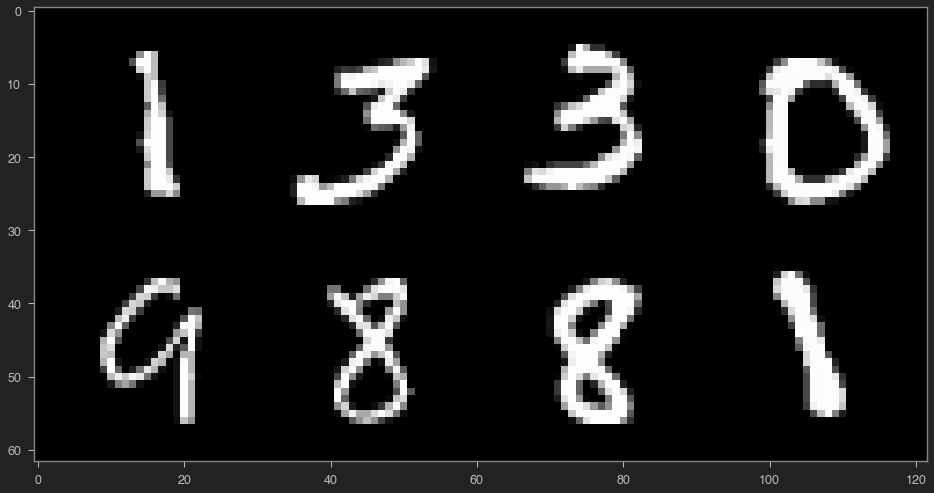

In [6]:
show_tensor_images(next(iter(val_disc_loader))[0], norm_mean=opt.norm_mean, norm_std=opt.norm_std)

In [7]:
len(next(iter(val_disc_loader))), next(iter(val_disc_loader))[-1].shape, next(iter(val_disc_loader))[0].shape

(2, torch.Size([128, 10]), torch.Size([128, 1, 28, 28]))

## Training

In [8]:
input_dim = (1, opt.img_height, opt.img_width)

model = DiscMNISTModel(
    input_dim, opt.n_classes, opt.disc_hidden_channels
).to(opt.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

In [9]:
summary(model, input_size=input_dim, batch_size=opt.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 24, 24]             416
              ReLU-2          [128, 16, 24, 24]               0
         MaxPool2d-3          [128, 16, 12, 12]               0
         Dropout2d-4          [128, 16, 12, 12]               0
            Conv2d-5            [128, 32, 8, 8]          12,832
              ReLU-6            [128, 32, 8, 8]               0
         Dropout2d-7            [128, 32, 8, 8]               0
         MaxPool2d-8            [128, 32, 4, 4]               0
            Linear-9                 [128, 102]          52,326
             ReLU-10                 [128, 102]               0
          Dropout-11                 [128, 102]               0
           Linear-12                  [128, 10]           1,030
Total params: 66,604
Trainable params: 66,604
Non-trainable params: 0
---------------------------------

In [10]:
train_disc_model(model, optimizer, scheduler, criterion, train_disc_loader, val_disc_loader, opt, target_metric='f1_avg', best_target_metric=-np.inf)

Epoch: [0][  0/235]	Time  2.712 ( 2.712)	Data  1.302 ( 1.302)	Loss 2.3201e+00 (2.3201e+00)	Acc   0.09 (  0.09)	F1   0.06 (  0.06)
Epoch: [0][ 10/235]	Time  0.082 ( 0.537)	Data  0.001 ( 0.119)	Loss 2.2882e+00 (2.2990e+00)	Acc   0.14 (  0.13)	F1   0.11 (  0.09)
Epoch: [0][ 20/235]	Time  0.046 ( 0.316)	Data  0.001 ( 0.063)	Loss 2.2716e+00 (2.2941e+00)	Acc   0.22 (  0.14)	F1   0.19 (  0.10)
Epoch: [0][ 30/235]	Time  0.044 ( 0.231)	Data  0.001 ( 0.043)	Loss 2.2509e+00 (2.2865e+00)	Acc   0.26 (  0.16)	F1   0.21 (  0.12)
Epoch: [0][ 40/235]	Time  0.093 ( 0.188)	Data  0.001 ( 0.033)	Loss 2.2352e+00 (2.2766e+00)	Acc   0.20 (  0.17)	F1   0.17 (  0.13)
Epoch: [0][ 50/235]	Time  0.049 ( 0.161)	Data  0.001 ( 0.026)	Loss 2.1627e+00 (2.2593e+00)	Acc   0.28 (  0.19)	F1   0.25 (  0.15)
Epoch: [0][ 60/235]	Time  0.046 ( 0.143)	Data  0.001 ( 0.022)	Loss 2.0665e+00 (2.2368e+00)	Acc   0.33 (  0.21)	F1   0.32 (  0.17)
Epoch: [0][ 70/235]	Time  0.045 ( 0.130)	Data  0.001 ( 0.019)	Loss 1.8858e+00 (2.2002e+00)

## Model performance metrics

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

In [12]:
model = DiscMNISTModel(
    input_dim, opt.n_classes, opt.disc_hidden_channels,
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'))
model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [13]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_disc_loader, model, opt.device)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 40/40 [00:01<00:00, 28.72it/s]

Accuracy: 0.965
F1: 0.965
Precision: 0.966
Recall: 0.965


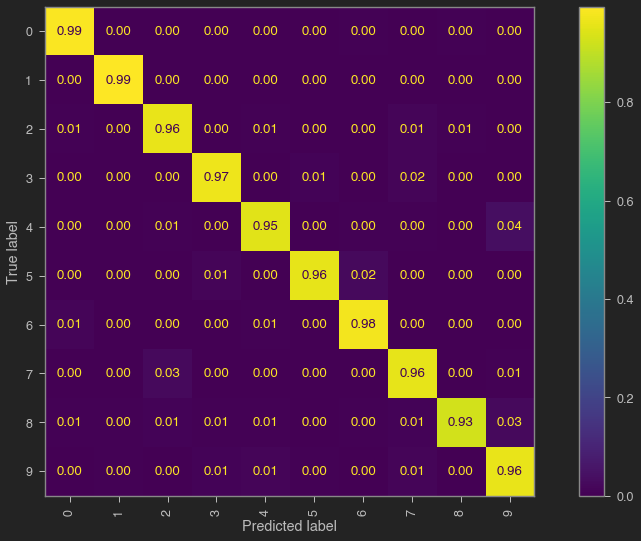

In [14]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

## Inference

In [15]:
from torchvision.datasets import MNIST
from utils.loops import infer_disc_one_image

In [16]:
infer_disc_dataset = MNIST(
    opt.path_to_data / 'mnist', download=True, train=False,
)

image = next(iter(infer_disc_dataset))[0]
target = next(iter(infer_disc_dataset))[1]
predicted = infer_disc_one_image(
    image, model, opt.device, transform=val_disc_transformations,
)

print(f'Predicted class: {predicted}; Target: {target}')

Predicted class: 7; Target: 7
